<a href="https://colab.research.google.com/github/nmatsumoto-lgtm/study-KIKAGAKU/blob/main/%E4%B8%8D%E5%8B%95%E7%94%A3%E4%BE%A1%E6%A0%BC%E4%BA%88%E6%B8%AC%E3%82%A2%E3%83%97%E3%83%AA_Ver_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install lightgbm==4.5.0 optuna==3.6.1 joblib pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 32.4 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass


import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error
from joblib import dump

In [3]:
SEED = 0
np.random.seed(SEED)

In [4]:
IN = Path("data/interim/train_tabular.csv")
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# ============================
# 1) データ読み込み & 追加特徴量
# ============================

def _oof_target_median(df: pd.DataFrame, key, y: np.ndarray, n_splits: int = 5) -> np.ndarray:
    """key は str でも list[str] でもOK。OOFで groupby(key) の中央値を割り当て。"""
    if isinstance(key, str):
        key_cols = [key]
    else:
        key_cols = list(key)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    key_df = df[key_cols].copy()
    for tr_idx, va_idx in kf.split(df):
        g = pd.DataFrame({"y": y[tr_idx]})
        for c in key_cols:
            g[c] = key_df.iloc[tr_idx][c].values
        med = g.groupby(key_cols)["y"].median()
        # map 用の結合キー（高速・簡易）
        tr_key = key_df.iloc[va_idx].astype(str).agg("§".join, axis=1)
        med_key = med.reset_index()
        med_key["__k__"] = med_key[key_cols].astype(str).agg("§".join, axis=1)
        map_dict = pd.Series(med_key["y"].values, index=med_key["__k__"]).to_dict()
        mapped = tr_key.map(map_dict)
        oof[va_idx] = mapped.fillna(float(np.median(y[tr_idx]))).values
    return oof

def build_table_and_features() -> tuple[ pd.DataFrame,            # X_df
    np.ndarray,              # y_log
    np.ndarray,              # y_rel
    list[str],               # categorical_feature (cat_cols)
    list[int],               # monotone_constraints
    dict,                    # meta
    OrdinalEncoder,          # oe
    dict                     # infer_maps
]:
    df = pd.read_csv(IN)

    # ===== 目標（対数）=====
    y = df["price_yen"].astype(float).values
    y_log = np.log1p(y)

    # ===== 追加特徴量 =====
    df["access_score"] = 1.0 / (1.0 + df["walk_min"].astype(float))
    df["sqrt_area"] = np.sqrt(np.clip(df["area_sqm"].astype(float), 0, None))
    df["log_area"] = np.log1p(np.clip(df["area_sqm"].astype(float), 0, None))
    df["age_sqrt"] = np.sqrt(np.clip(df["築年数"].astype(float), 0, None))
    df["area_x_access"] = df["area_sqm"].astype(float) * df["access_score"].astype(float)

    # 取引年（欠損は全体中央値で補完）
    if "txn_year" in df.columns:
        df["txn_year"] = pd.to_numeric(df["txn_year"], errors="coerce")
        df["txn_year"] = df["txn_year"].fillna(df["txn_year"].median())
    else:
        # 取引年が無いデータでも動くように、現在年で埋める
        df["txn_year"] = datetime.now().year

    # 年の離散化（木が扱いやすい整数カテゴリ）
    df["txn_year_int"] = df["txn_year"].round().astype(int)

    # ★ 追加：半年ビン（例: 2024H1=4048, 2024H2=4049）
    df["txn_half"] = (df["txn_year"] * 2).round().astype(int)

    # 頻度特徴量
    station_cnt = df["station"].value_counts()
    layout_cnt  = df["layout"].value_counts()
    df["station_count"] = df["station"].map(station_cnt).fillna(0).astype(int)
    df["layout_count"]  = df["layout"].map(layout_cnt).fillna(0).astype(int)

    # OOF 目標エンコード（駅/間取り/駅×年） ※対数ターゲットで作る
    df["station_oof_median_log"]      = _oof_target_median(df, "station", y_log)
    df["layout_oof_median_log"]       = _oof_target_median(df, "layout",  y_log)
    df["station_year_oof_median_log"] = _oof_target_median(df, ["station", "txn_year_int"], y_log)
    # ★ 追加
    df["station_half_oof_median_log"] = _oof_target_median(df, ["station", "txn_half"], y_log)

    # 推論時に使う学習時統計
    station_med_map = pd.DataFrame({"station": df["station"], "y_log": y_log}).groupby("station")["y_log"].median().to_dict()
    layout_med_map  = pd.DataFrame({"layout":  df["layout"],  "y_log": y_log}).groupby("layout")["y_log"].median().to_dict()
    st_year_med_map = (pd.DataFrame({"station": df["station"], "year": df["txn_year_int"], "y_log": y_log})
                       .groupby(["station","year"])["y_log"].median().to_dict())
    # ★ 追加：駅×半年の中央値
    st_half_med_map = (pd.DataFrame({"station": df["station"], "half": df["txn_half"], "y_log": y_log})
                   .groupby(["station","half"])["y_log"].median().to_dict())

    global_station_med = float(np.median(list(station_med_map.values()))) if len(station_med_map) else float(np.median(y_log))
    global_layout_med  = float(np.median(list(layout_med_map.values())))  if len(layout_med_map)  else float(np.median(y_log))

    # カテゴリ列
    feat_cat = ["station", "layout", "txn_year_int"]  # 年もカテゴリとして持たせる

    # 数値列（順序固定）
    feat_num_base = ["walk_min", "築年数", "area_sqm"]
    feat_num_extra = [
        "access_score", "sqrt_area", "log_area", "age_sqrt",
        "area_x_access", "station_count", "layout_count",
        "station_oof_median_log", "layout_oof_median_log",
        "station_year_oof_median_log",
        # ★ 追加
        "station_half_oof_median_log",
    ]
    feat_num_all = feat_num_base + feat_num_extra

    # 単調性制約（[cat..., num...] の順）— 名前ベースで安全に設定
    mono_dict = {name: 0 for name in feat_num_all}
    mono_dict.update({
        "walk_min": -1,     # 遠いほど価格↓
        "築年数": -1,        # 古いほど価格↓
        "area_sqm": +1,     # 広いほど価格↑
        "access_score": +1, # 駅近スコアが高いほど価格↑
        "age_sqrt": -1,     # 平滑化した築年数も価格↓
    })
    mono_num = [mono_dict[name] for name in feat_num_all]
    monotone_constraints = [0] * len(feat_cat) + mono_num

    # ====== エンコードして学習用テーブル ======
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = oe.fit_transform(df[feat_cat].fillna("NA")).astype("int32")
    X_num = df[feat_num_all].astype(float).values
    X = np.hstack([X_cat, X_num])

    cat_cols = [f"cat__{c}" for c in feat_cat]
    num_cols = feat_num_all.copy()
    X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
    categorical_feature = cat_cols

    meta = {
        "feat_cat": feat_cat,
        "feat_num": num_cols,
        "categorical_feature": categorical_feature,
        "monotone_constraints": monotone_constraints,
    }

    meta["cv_info"] = {
       "year_int": df["txn_year_int"].astype(int).values.tolist(),
       "station":  df["station"].astype(str).values.tolist(),
    }

    infer_maps = {
        "station_count_map": station_cnt.to_dict(),
        "layout_count_map": layout_cnt.to_dict(),
        "station_median_log_map": station_med_map,
        "layout_median_log_map": layout_med_map,
        "station_year_median_log_map": {f"{k[0]}§{k[1]}": float(v) for k, v in st_year_med_map.items()},
        # ★ 追加
        "station_half_median_log_map": {f"{k[0]}§{k[1]}": float(v) for k, v in st_half_med_map.items()},
        "global_station_median_log": global_station_med,
        "global_layout_median_log": global_layout_med,
        "feat_cat": feat_cat,
        "feat_num": num_cols,
    }

    # ★ 追加：学習用の相対ターゲット y_rel = y_log - base_log
    base_key = df["station"].astype(str) + "§" + df["txn_half"].astype(int).astype(str)
    base_log = base_key.map(infer_maps["station_half_median_log_map"]).fillna(float(np.median(y_log)))
    y_rel = y_log - base_log.values

    return X_df, y_log, y_rel, categorical_feature, monotone_constraints, meta, oe, infer_maps


#LightGBMの単調性制約
単調性制約とは？
LightGBMに「この特徴量は必ず上がる／下がる方向に効くはずだよ」と教える機能です。

例：

* 徒歩時間（walk_min） → 長くなると価格は 下がる はず → 制約「負」
* 面積（area_sqm） → 広くなると価格は 上がる はず → 制約「正」
* 築年数 → 古くなると価格は 下がる はず → 制約「負」

なぜ必要なのか？

木モデルは柔軟すぎるので、
データが少ない領域では「徒歩20分のほうが徒歩10分より高い」といった直感に反する予測をしてしまうことがあります。

単調性制約を入れると、それを防いで「人間の常識に合った」予測を保証できます。


-->単調性制約は「ドメイン知識を組み込む」ためのテクニック。

#特徴量一覧
* カテゴリ特徴量（OrdinalEncoder で数値化）
  - station … 最寄駅の名称
  - layout … 間取り（例: 2LDK, 1K などを正規化したもの）
  - txn_year_int … 取引年（整数化したカテゴリ）
* 数値特徴量
  - walk_min … 最寄駅からの徒歩分数
  - 築年数 … 取引年 − 建築年
  - area_sqm … 専有面積（㎡）
* 数値特徴量（追加で作った派生＆統計的特徴量）
  - access_score = 1 / (1 + walk_min)
   → 駅近ほど大きい値になるアクセススコア
  - sqrt_area = sqrt(area_sqm)
   → 面積の平方根（非線形性を吸収）
  - log_area = log1p(area_sqm)
   → 面積の対数（大きい面積の伸びを抑える）
  - age_sqrt = sqrt(築年数)
   → 築年数の平方根（築年数の影響を平滑化）
  - area_x_access = area_sqm × access_score
   → 面積とアクセスを掛け合わせた交互作用特徴量
  - station_count = 各駅の出現回数（頻度エンコード）
  - layout_count = 各間取りの出現回数（頻度エンコード）
  - station_oof_median_log = 駅ごとの取引価格中央値（OOF方式で計算）
  - layout_oof_median_log = 間取りごとの取引価格中央値（OOF方式で計算）
  - station_year_oof_median_log = 駅 × 年ごとの取引価格中央値（OOF方式で計算）



In [6]:
# ============================
# 2) Optuna でハイパラ探索
# ============================
def iter_ts_station_cv(year_int: np.ndarray, station: np.ndarray,
                       n_folds: int = 5, holdout_frac: float = 0.2, seed: int = 0):
    years = np.array(year_int).astype(int)
    st    = np.array(station).astype(str)
    uniq_years = np.unique(years)
    if len(uniq_years) < n_folds:
        n_folds = len(uniq_years)
    fold_years = uniq_years[-n_folds:]

    for i, vy in enumerate(fold_years):
        va_mask_year = (years == vy)
        rng = np.random.RandomState(seed + int(vy))
        st_in_year = np.unique(st[va_mask_year])
        k = max(1, int(np.ceil(len(st_in_year) * holdout_frac)))
        hold_st = rng.choice(st_in_year, size=k, replace=False)
        va_mask = va_mask_year & np.isin(st, hold_st)
        tr_mask = years < vy
        tr_idx = np.where(tr_mask)[0]
        va_idx = np.where(va_mask)[0]
        if len(va_idx) == 0 or len(tr_idx) == 0:
            continue
        yield tr_idx, va_idx

def tune_with_optuna(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    n_trials: int = 120,
    cv_mode: str = "kfold",         # ★ 追加: "kfold" | "ts_station"
    cv_info: dict | None = None,    # ★ 追加
) -> tuple[dict, int, float]:
    # kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    # 新（★ cv_mode 切替）
    if cv_mode == "ts_station" and cv_info is not None:
          splits = list(iter_ts_station_cv(
              np.array(cv_info["year_int"]), np.array(cv_info["station"]),
              n_folds=5, holdout_frac=0.2, seed=SEED))
    else:
          from sklearn.model_selection import KFold
          splits = list(KFold(n_splits=5, shuffle=True, random_state=SEED).split(X_df))

    def objective(trial: optuna.Trial) -> float:
        params = {
                "objective": "rmse",
                "metric": "rmse",
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.08, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 31, 255),              # ★ 広げる
                "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 300),  # ★ 広げる
                "min_sum_hessian_in_leaf": trial.suggest_float("min_sum_hessian_in_leaf", 1e-3, 1e-1, log=True),  # ★ 追加
                "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.95),
                "feature_fraction_bynode": trial.suggest_float("feature_fraction_bynode", 0.6, 0.95),             # ★ 追加
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
                "max_bin": trial.suggest_int("max_bin", 255, 1023),                  # ★ 追加
                "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 3.0),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 3.0, log=True),  # ★ 上限↑
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 3.0, log=True),  # ★ 上限↑
                "extra_trees": trial.suggest_categorical("extra_trees", [False, True]),  # ★ 追加
                "verbosity": -1,
                "seed": SEED,
                "monotone_constraints": monotone_constraints,
         }

        rmsles, best_iters = [], []
        for tr_idx, va_idx in splits:
            X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            y_tr, y_va = y_log[tr_idx], y_log[va_idx]
            dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_feature, free_raw_data=True)
            dva = lgb.Dataset(X_va, label=y_va, categorical_feature=categorical_feature, free_raw_data=True)

            model = lgb.train(
                params,
                dtr,
                valid_sets=[dva],
                num_boost_round=4000,
                callbacks=[lgb.early_stopping(300, verbose=False)],  # ← 少し長めに
            )
            pred_log = model.predict(X_va, num_iteration=model.best_iteration)
            # rmsle = float(np.sqrt(mean_squared_log_error(np.expm1(y_va), np.expm1(pred_log))))
            # rmsles.append(rmsle)
            rmse_rel = float(np.sqrt(np.mean((y_va - pred_log) ** 2)))
            rmsles.append(rmse_rel)
            best_iters.append(model.best_iteration)
        trial.set_user_attr("best_iters", best_iters)
        return float(np.mean(rmsles))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_iters_list = study.best_trial.user_attrs.get("best_iters", [1000])
    best_round = int(np.clip(np.mean(best_iters_list), 100, 4000))
    best_score = study.best_value
    return best_params, best_round, best_score

In [7]:
# ============================
# 3) 最終学習（ポイント & 分位点）
# ============================

def train_final_models(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    best_params: dict,
    best_round: int,
):
    base_params = dict(best_params)
    base_params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        # ★ ポイントモデルでは単調性制約を使う
        "monotone_constraints": monotone_constraints,
    })

    # 生データを解放しない（categorical_feature を後で使えるように）
    dtrain = lgb.Dataset(
        X_df,
        label=y_log,
        categorical_feature=categorical_feature,
        free_raw_data=False
    )

    # ---- ポイント（対数価格）----
    model_point = lgb.train(base_params, dtrain, num_boost_round=best_round)

    # ---- 分位点（q10/q90）----
    models_q = {}
    for alpha, tag in [(0.1, "q10"), (0.9, "q90")]:
        q_params = dict(best_params)
        q_params.update({
            "objective": "quantile",
            "alpha": alpha,
            "metric": "quantile",
            "verbosity": -1,
            "seed": SEED,
            # ★ ここが重要：quantile では単調性制約を外す
            # "monotone_constraints": monotone_constraints,  # ←入れない
        })
        models_q[tag] = lgb.train(q_params, dtrain, num_boost_round=best_round)

    return model_point, models_q


In [8]:
# ===== 入力CSV→中間CSVの自動生成（なければ作る） =====
from pathlib import Path
import pandas as pd, numpy as np, re
from datetime import datetime

RAW_CSV = Path("/content/Tokyo_Chuo Ward_20222_20251.csv")
IN = Path("data/interim/train_tabular.csv")
ST_OUT = Path("data/interim/stations.csv")
IN.parent.mkdir(parents=True, exist_ok=True)

def _read_chuo_and_save(raw_csv: Path, out_csv: Path, stations_csv: Path):
    # エンコーディングを順に試す（Excel想定）
    last_err = None
    for enc in ("cp932", "utf-8-sig", "utf-8", "utf-16", "utf-16le", "utf-16be"):
        try:
            raw = pd.read_csv(raw_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise last_err

    # ---- 年の抽出（和暦/西暦対応）----
    def _to_year(x):
        if pd.isna(x): return np.nan
        s = str(x)
        m = re.search(r"(\d{4})年", s)
        if m: return int(m.group(1))
        era_base = {"令和":2018, "平成":1988, "昭和":1925}
        for era, base in era_base.items():
            m = re.search(fr"{era}\s*(\d+)年", s)
            if m: return base + int(m.group(1))
        return np.nan

    # ---- 取引年（列が無ければ建物の保存年やファイル名からフォールバック）----
    def _to_txn_year(s):
        if pd.isna(s): return np.nan
        ss = str(s)
        # 例: "2024年第2四半期", "2023年上半期" などから西暦抽出
        m = re.search(r"(\d{4})", ss)
        return float(m.group(1)) if m else np.nan

    # 欲しい列が増えても落ちないように存在チェック
    need_base = ["最寄駅：名称","最寄駅：距離（分）","間取り","面積（㎡）","建築年","取引価格（総額）"]
    miss = [c for c in need_base if c not in raw.columns]
    if miss:
        raise KeyError(f"必要列が見つかりません: {miss}")
    df = raw[need_base].copy()

    # 取引時期があれば読む
    txn_year = None
    if "取引時期" in raw.columns:
        txn_year = raw["取引時期"].apply(_to_txn_year)
    # 全欠損なら建築年からの近似（現行の現在年は避ける）
    if txn_year is None or txn_year.isna().all():
        # ファイル名に西暦があれば拾う（例: Tokyo_Chuo Ward_20242_20251.csv → 2024〜2025）
        mfile = re.findall(r"(20\d{2})", raw_csv.name)
        fallback_year = float(mfile[-1]) if mfile else np.nan
        txn_year = pd.Series(fallback_year, index=df.index, dtype="float64")

    # ---- 築年数 = 取引年 − 建築年 ----
    build_year = df["建築年"].apply(_to_year)
    df["txn_year"] = txn_year.astype(float)
    df["築年数"] = (df["txn_year"] - build_year).clip(lower=0)

    # ---- 数値化ユーティリティ ----
    def _to_num_series(s):
        s = s.astype(str).str.replace(r"[^\d\.]", "", regex=True)
        return pd.to_numeric(s, errors="coerce")

    # ---- 数値列の強制数値化 & 欠損補完 ----
    for col in ["最寄駅：距離（分）","面積（㎡）","築年数"]:
        s_num = _to_num_series(df[col])
        med = s_num.median()
        if pd.isna(med):
            defaults = {"最寄駅：距離（分）":10.0, "面積（㎡）":40.0, "築年数":20.0}
            med = defaults.get(col, 0.0)
        df[col] = s_num.fillna(med)

    # ---- 間取りの正規化 ----
    def _normalize_layout(s):
        if not isinstance(s,str): return "その他"
        s = s.upper().replace("Ｌ","L").replace("Ｄ","D").replace("Ｋ","K").replace("Ｒ","R")
        m = re.search(r"(\d+)(LDK|DK|K|R)", s)
        return m.group(0) if m else "その他"

    # ---- 学習用テーブル ----
    train = df.rename(columns={
        "最寄駅：名称":"station",
        "最寄駅：距離（分）":"walk_min",
        "面積（㎡）":"area_sqm",
        "取引価格（総額）":"price_yen",
    })[["station","walk_min","築年数","area_sqm","price_yen","txn_year"]].copy()
    train["layout"] = raw["間取り"].astype(str).apply(_normalize_layout)

    # 不適切値の除去とクリップ
    train["price_yen"] = _to_num_series(train["price_yen"]).fillna(0)
    train = train[
        (train["price_yen"] > 0) &
        (train["area_sqm"]  > 0) &
        (train["walk_min"]  >= 0) &
        (train["築年数"]      >= 0)
    ].copy()
    train["area_sqm"] = train["area_sqm"].clip(8, 300)
    train["walk_min"] = train["walk_min"].clip(0, 60)

    # 保存
    train.to_csv(out_csv, index=False)

    # 駅リスト
    s = (raw["最寄駅：名称"].astype(str)
           .replace({"nan":np.nan,"None":np.nan,"":np.nan})
           .dropna()
           .str.normalize("NFKC")
           .str.replace("（","(",regex=False).str.replace("）",")",regex=False)
           .str.replace("　"," ",regex=False).str.strip()
           .str.replace(r"\s+"," ",regex=True))
    pd.Series(sorted(s.unique())).to_csv(stations_csv, index=False, header=False, encoding="utf-8-sig")


# まだ中間CSVがない場合は作る
if not IN.exists():
    if not RAW_CSV.exists():
        raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
    _read_chuo_and_save(RAW_CSV, IN, ST_OUT)

In [14]:
# ============================
# 4) 実行
# ============================

if __name__ == "__main__":
    assert IN.exists(), f"Not found: {IN}"

    # # ★ infer_maps まで受け取る（関数が infer_maps を返す実装になっている前提）
    # X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps = build_table_and_features()
    X_df, y_log, y_rel, cat_cols, mono_cons, meta, oe, infer_maps = build_table_and_features()
    print(f"Train rows: {len(X_df):,}, cols: {X_df.shape[1]} (cats={len(cat_cols)})")

    # best_params, best_round, best_score = tune_with_optuna(
    #     X_df, y_log, cat_cols, mono_cons, n_trials=80
    # )
    # print("[OPTUNA] best RMSLE:", round(best_score, 4))
    # print("[OPTUNA] best params:")
    # for k, v in best_params.items():
    #     print(f"  {k}: {v}")
    # print("[OPTUNA] best_round:", best_round)

    # ★ 学習・探索は y_rel を使う（相対ターゲット）
    best_params, best_round, best_score = tune_with_optuna(
       X_df, y_rel, cat_cols, mono_cons,
       n_trials=120,                # 後述の探索拡大に合わせて少し増やす
       cv_mode="ts_station",        # 後述のCV切替
       cv_info=meta.get("cv_info")  # 後述のCV用情報
    )

    model_point, models_q = train_final_models(
    X_df, y_rel, cat_cols, mono_cons, best_params, best_round
    )

    # ===== 保存 =====
    # 予測時に使うメタ情報（列順や制約）とエンコーダを一緒に保存しておく
    dump({
         "model": model_point,
         "encoder": oe,
         "cat_cols": meta["feat_cat"],
         "num_cols": meta["feat_num"],
         "categorical_feature": meta["categorical_feature"],
         "monotone_constraints": meta["monotone_constraints"],
         "target": "log_price_yen_rel",   # ★ 相対ターゲットで学習した場合はこちら
         "relative_info": {               # ★ 予測時に基準へ戻すための情報
         "base_key": "station§txn_half",
         "maps": {"station_half_median_log_map": True}
         },
    }, OUT_DIR / "lgbm_optuna_point.pkl")


    dump({
        "model": models_q["q10"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen_rel",   # ★ 相対ターゲット
        "alpha": 0.1,
        "relative_info": {               # ★ 基準へ戻すための情報
        "base_key": "station§txn_half",
        "maps": {"station_half_median_log_map": True}
        },
    }, OUT_DIR / "lgbm_optuna_q10.pkl")

    dump({
        "model": models_q["q90"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen_rel",   # ★ 相対ターゲット
        "alpha": 0.9,
        "relative_info": {               # ★ 同上
        "base_key": "station§txn_half",
        "maps": {"station_half_median_log_map": True}
        },
   }, OUT_DIR / "lgbm_optuna_q90.pkl")

    with open(OUT_DIR / "feature_config.json", "w", encoding="utf-8") as f:
        json.dump({
            "feat_cat": meta["feat_cat"],
            "feat_num": meta["feat_num"],
            "categorical_feature": meta["categorical_feature"],
            "monotone_constraints": meta["monotone_constraints"],
            "notes": (
            "target is relative: y_rel = log1p(price_yen) - base_log(station×half). "
            "During inference, add base_log back then apply expm1."
           ),
    }, f, ensure_ascii=False, indent=2)

    # ★ 推論用マップも保存（カッコを閉じるのを忘れない）
    with open(OUT_DIR / "infer_maps.json", "w", encoding="utf-8") as f:
        json.dump(infer_maps, f, ensure_ascii=False, indent=2)

    # === 手早く確認：学習データに対する MAE / RMSLE ===
    from sklearn.metrics import mean_absolute_error, mean_squared_log_error
    import numpy as np, pandas as pd

    # 駅×半年キー（学習時に作った map を使う）
    station_s = pd.Series(meta["cv_info"]["station"], dtype=str)
    half_s    = pd.Series(meta["cv_info"]["year_int"], dtype=int) * 2  # txn_half ≒ 年×2
    key = station_s + "§" + half_s.astype(str)

    st_half_map = infer_maps["station_half_median_log_map"]
    fallback_log = float(np.median(y_log))
    base_log = key.map(st_half_map).fillna(fallback_log).to_numpy()

    # 相対ログ予測 → 絶対ログ → 円スケール
    pred_rel_log = model_point.predict(X_df, num_iteration=getattr(model_point, "best_iteration", None))
    pred_price   = np.expm1(pred_rel_log + base_log)

    y_true = np.expm1(y_log)

    mae   = float(np.mean(np.abs(y_true - pred_price)))
    rmsle = float(np.sqrt(mean_squared_log_error(y_true, pred_price)))
    print(f"[Train/In-sample] MAE: {mae:,.0f} JPY  |  RMSLE: {rmsle:.5f}")

    print("Saved models →", OUT_DIR)


[I 2025-09-05 05:50:29,363] A new study created in memory with name: no-name-e3c4117f-0143-4a3f-877d-3cbfca44f946


Train rows: 5,333, cols: 17 (cats=3)


[I 2025-09-05 05:50:29,994] Trial 0 finished with value: 0.26218925968345147 and parameters: {'learning_rate': 0.017330929683802176, 'num_leaves': 215, 'min_data_in_leaf': 224, 'min_sum_hessian_in_leaf': 0.009510374189017162, 'feature_fraction': 0.8235582364371123, 'feature_fraction_bynode': 0.8784642891091843, 'bagging_fraction': 0.7197409833779014, 'bagging_freq': 9, 'max_bin': 832, 'min_gain_to_split': 0.44269028638406427, 'lambda_l1': 7.586876039401349e-06, 'lambda_l2': 0.0004987760334587165, 'extra_trees': True}. Best is trial 0 with value: 0.26218925968345147.
[I 2025-09-05 05:50:30,138] Trial 1 finished with value: 0.2798410415601234 and parameters: {'learning_rate': 0.07741177404450028, 'num_leaves': 210, 'min_data_in_leaf': 143, 'min_sum_hessian_in_leaf': 0.09566843846794758, 'feature_fraction': 0.7870695995580166, 'feature_fraction_bynode': 0.8127707326063295, 'bagging_fraction': 0.9650843941846035, 'bagging_freq': 4, 'max_bin': 544, 'min_gain_to_split': 2.9215610733961084, '

[Train/In-sample] MAE: 9,591,764 JPY  |  RMSLE: 0.15583
Saved models → models


                        feature   importance
8                      log_area  2937.347384
14        layout_oof_median_log  1814.421704
7                     sqrt_area  1667.804282
1                   cat__layout  1437.711707
5                      area_sqm  1111.681845
16  station_half_oof_median_log  1026.509667
4                           築年数   838.412723
15  station_year_oof_median_log   613.687606
0                  cat__station   596.564659
9                      age_sqrt   582.436878
13       station_oof_median_log   400.968409
10                area_x_access   400.955678
11                station_count   179.241487
2             cat__txn_year_int   168.806124
12                 layout_count    37.537404
3                      walk_min    27.631959
6                  access_score    26.441663


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


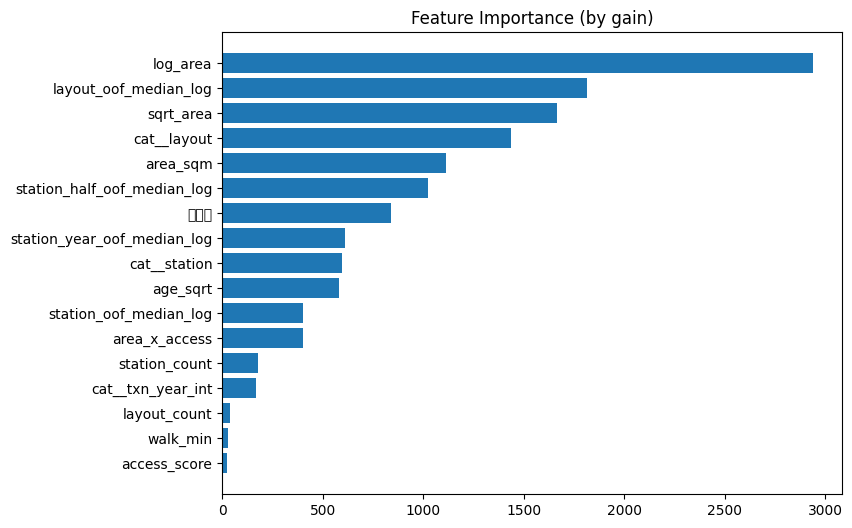

In [10]:
import matplotlib.pyplot as plt

# 重要度を取得
importance = model_point.feature_importance(importance_type="gain")
feature_names = model_point.feature_name()

# DataFrame化
import pandas as pd
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(fi)

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (by gain)")
plt.show()

In [11]:
!pip install shap

/tmp/ipython-input-550421581.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_df, plot_type="dot")
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missi

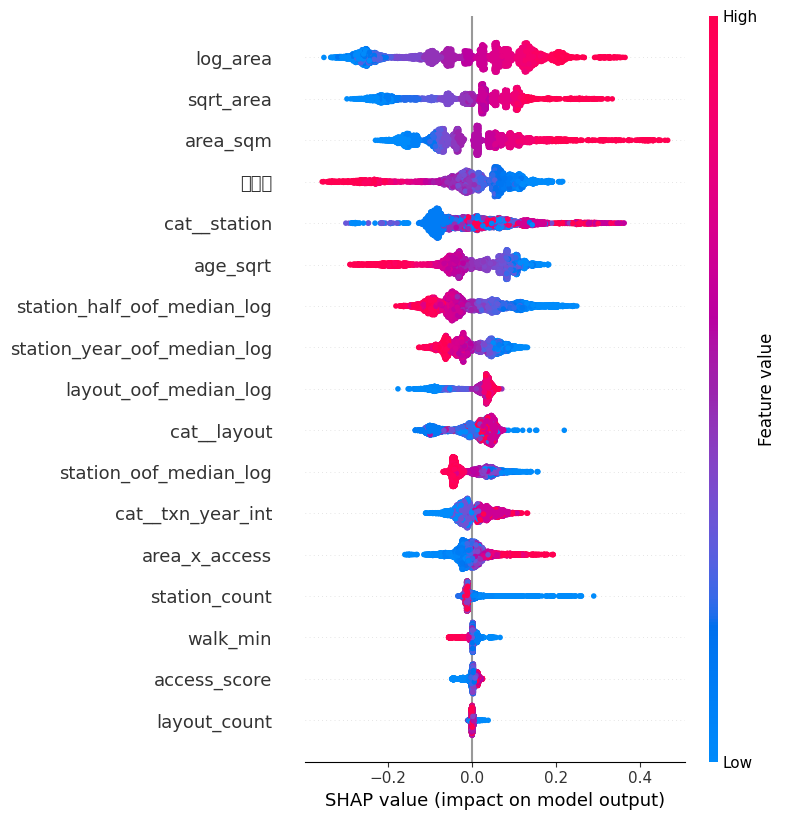

/tmp/ipython-input-550421581.py:13: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_df, plot_type="bar")
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missi

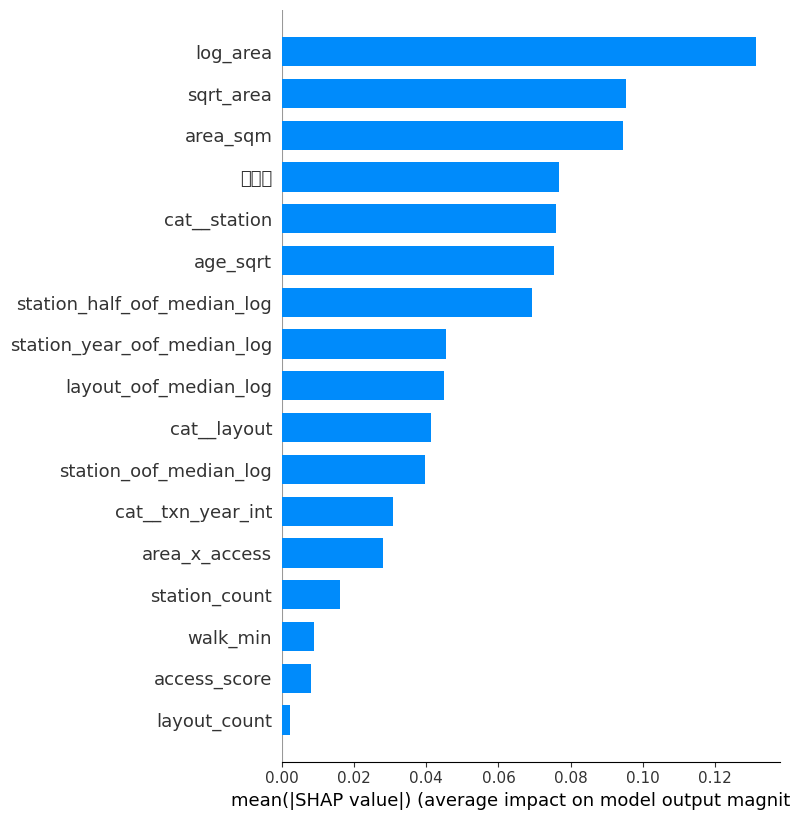

In [12]:
import shap

# 学習済みモデル（model_point）と学習データ（X_df）がある前提

# SHAPのExplainerを作成
explainer = shap.TreeExplainer(model_point)
shap_values = explainer.shap_values(X_df)

# ① 全体の重要度＋影響方向（サマリープロット）
shap.summary_plot(shap_values, X_df, plot_type="dot")

# ② 棒グラフ版（特徴量の寄与度だけ）
shap.summary_plot(shap_values, X_df, plot_type="bar")

# ③ 個別予測の説明（1件だけ取り出す例）
shap.force_plot(explainer.expected_value, shap_values[0,:], X_df.iloc[0,:])